In [5]:
import os
join = os.path.join
import numpy as np
from glob import glob
import torch
from segment_anything.build_sam3D import sam_model_registry3D
from segment_anything.utils.transforms3D import ResizeLongestSide3D
from segment_anything import sam_model_registry
from tqdm import tqdm
import argparse
import SimpleITK as sitk
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchio as tio
import numpy as np
from collections import OrderedDict, defaultdict
import json
import pickle
from utils.click_method import get_next_click3D_torch_ritm, get_next_click3D_torch_2
import utils.data_loader 
import einops as E
import torch
Dataset_Union_ALL_Val = utils.data_loader.Dataset_Union_ALL_Val


In [6]:
# hardcode for juptyer notebook compatability

args = argparse.Namespace(
    test_data_path = '/home/t722s/Desktop/Datasets/BratsTestData/',
    checkpoint_path=  '',
    results_save_path='/home/t722s/Desktop/Sam-Med3DTest/evalBrats/',
    model='SAM-Med3D',
    seed=2023,
    dim = 3,
    crop_size = 128,
    data_type = 'Ts',
    split_num = 1,
    split_idx = 0,
)

points_path = os.path.join(args.results_save_path, 'prompts.pkl')

SEED = args.seed
print("set seed as", SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

if torch.cuda.is_available():
    torch.cuda.init()

# Obtain dataloaders
infer_transform = [
    tio.ToCanonical(),
    tio.CropOrPad(mask_name='points', target_shape=(args.crop_size,args.crop_size,args.crop_size)), # Will center the cropping/padding at the center of the bounding box of the clicks supplied.
]

test_dataset = Dataset_Union_ALL_Val(
    paths=args.test_data_path, 
    mode="Val", 
    dim = 3,
    label = 1,
    points_path = points_path,
    data_type=args.data_type, 
    transform=tio.Compose(infer_transform),
    threshold=0,
    split_num=args.split_num,
    split_idx=args.split_idx,
    pcc=False,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    sampler=None,
    batch_size=1, 
    shuffle=True
    )

set seed as 2023


In [162]:
from importlib import reload
reload(utils.data_loader)
Dataset_Union_ALL_Val = utils.data_loader.Dataset_Union_ALL_Val

In [7]:
image_paths = ['/home/t722s/Desktop/Datasets/BratsTestData/imagesTs/BraTS2021_01646.nii.gz']
label_paths = ['/home/t722s/Desktop/Datasets/BratsTestData/labelsTs/BraTS2021_01646.nii.gz']
dim = 2
label = 1

infer_transform = [
        tio.ToCanonical(),
        tio.CropOrPad(mask_name='points_mask', target_shape=(args.crop_size,args.crop_size,args.crop_size)), # Will center the cropping/padding at the center of the bounding box of the clicks supplied.
    ]

transform = tio.Compose(infer_transform)

with open(points_path, 'rb') as f:
    points_dict = pickle.load(f)

index = 0

tio_image = tio.ScalarImage.from_sitk(sitk.ReadImage(image_paths[index]))


#### UNDER CONSTRUCTION
# Load in points for this image and change to a mask to be usable by torchio
points = points_dict[os.path.basename(image_paths[index])][label][str(dim) + 'D']
points_mask = np.zeros(shape = (tio_image.shape[3], tio_image.shape[2], tio_image.shape[1])) # Skip the color channel for now; reintroduce in label_map definition. Reverse order since sitk uses WHD while numpy uses DHW
points_mask[*points.T] = 1
points_mask = E.rearrange(points_mask, pattern = 'x y z -> z y x') # Rearrange back to sitk WHD

points_mask = tio.LabelMap(tensor = torch.from_numpy(points_mask).float().unsqueeze(0), affine = tio_image.affine)

subject = tio.Subject(
    image = tio_image,
    points_mask = points_mask,
    label = tio.ScalarImage.from_sitk(sitk.ReadImage(label_paths[index])),
)

if '/ct_' in image_paths[index]:
    subject = tio.Clamp(-1000,1000)(subject)

if transform:
    try:
        subject = transform(subject)
    except:
        print(image_paths[index])


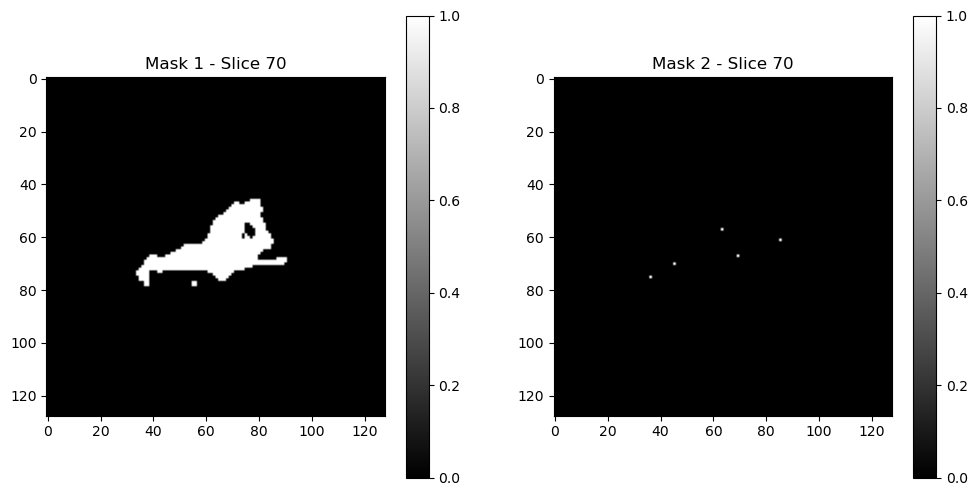

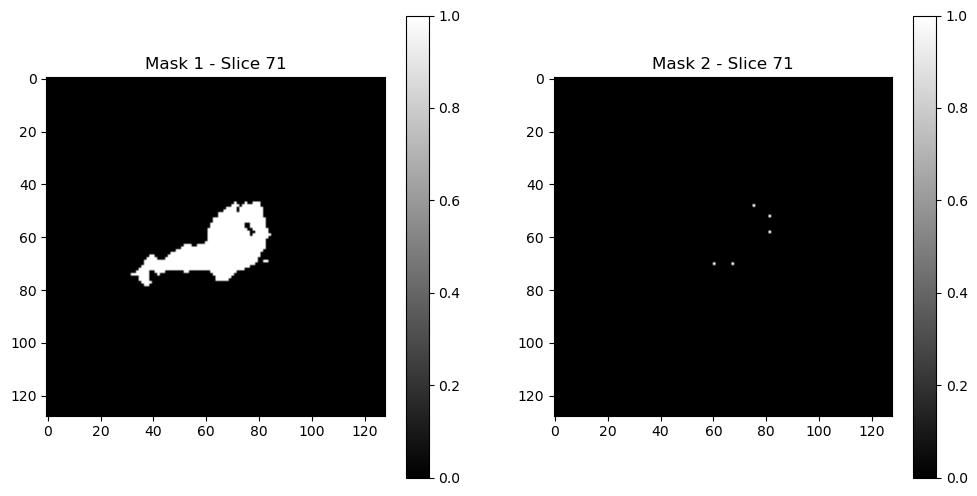

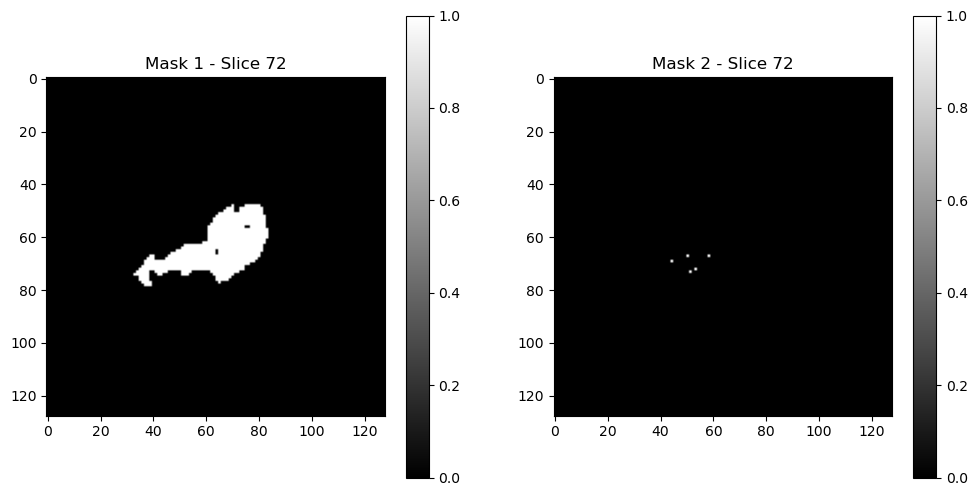

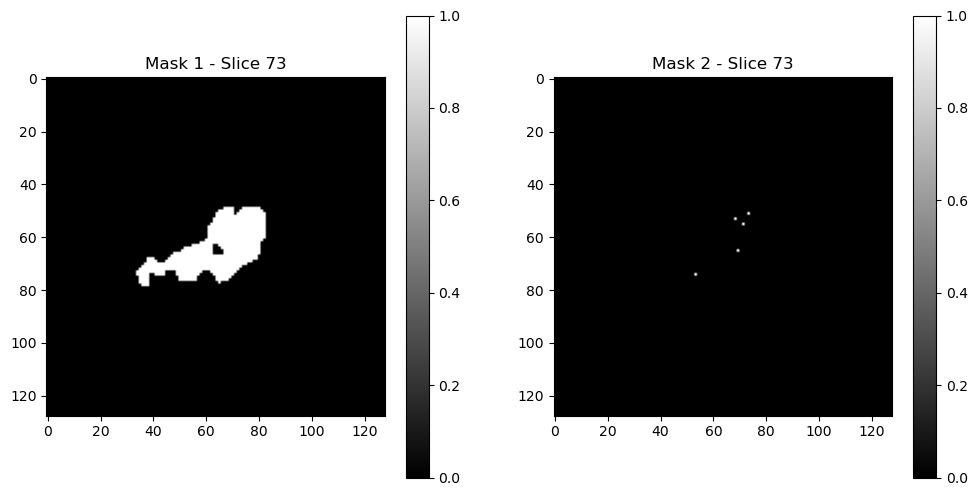

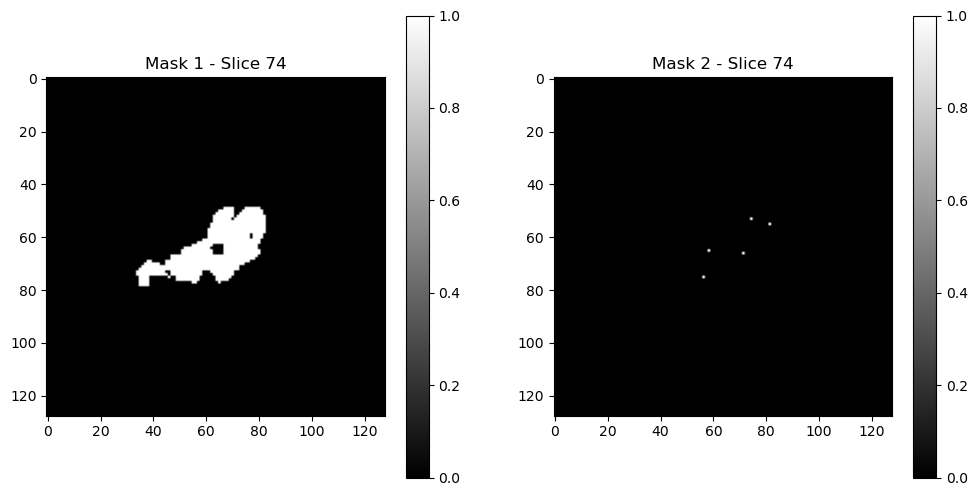

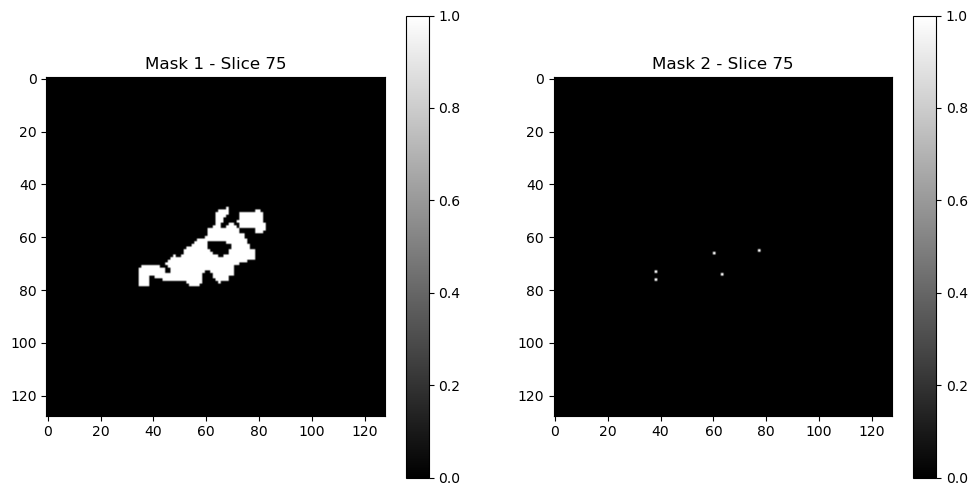

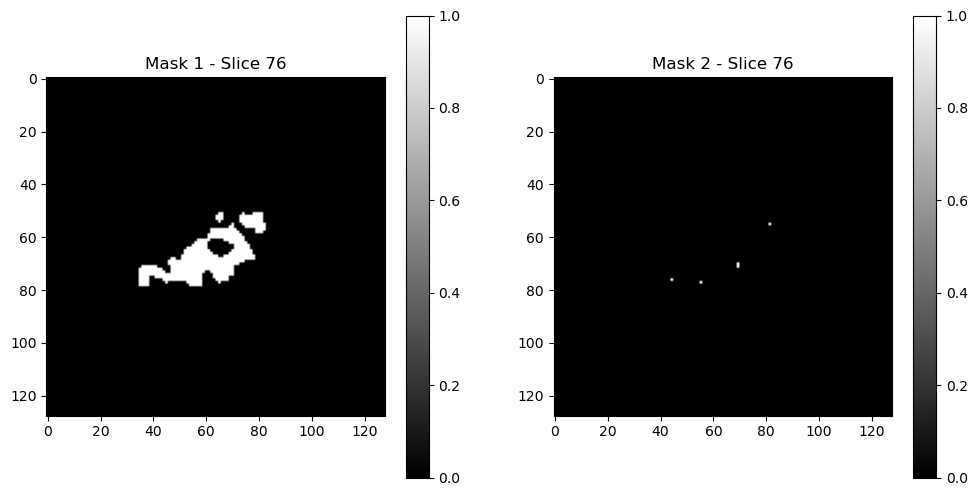

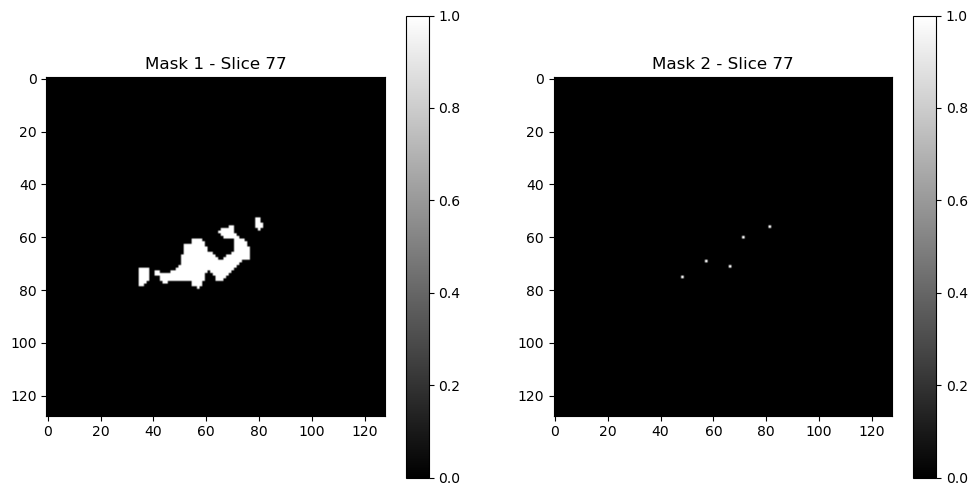

KeyboardInterrupt: Interrupted by user

In [240]:
import matplotlib.pyplot as plt


for i in range(70,80):
    plt.figure(figsize=(12, 6))

    # Display first mask's slice
    plt.subplot(1, 2, 1)
    plt.imshow(subject.label.data[0, :, :, i], cmap='gray')
    plt.title(f'Mask 1 - Slice {i}')
    plt.colorbar()

    # Display second mask's slice
    plt.subplot(1, 2, 2)
    plt.imshow(subject.points_mask.data[0, :, :,i], cmap='gray')
    plt.title(f'Mask 2 - Slice {i}')
    plt.colorbar()

    plt.show()
    input("Press Enter to continue to the next set of slices...")
